# Naive Bayes High Low Return Prediction Analysis
**German Hernandez**

Based on the post [Machine Learning on Quantopian - Thomas Wiecki ](https://www.quantopian.com/posts/machine-learning-on-quantopian) in Quantopian

This Notebook uses a **Gaussian Naive Bayes model** to predict if a stock will have a return **n_fwd_days** after that will be in the  **top percentile% of returns (class 1)** of the **lower  percentile% (class -1)** using as input variables the returns of 1,2,3,,4,5,6,7,8,9 and 10 days before .

In [1]:
n_fwd_days = 5 # number of days to compute returns over

percentile = 25 # target percetile of the prediction

We use dayly returns of the good quality Quantopian tradable stocks [QTradableStocksUS()](https://www.quantopian.com/posts/working-on-our-best-universe-yet-qtradablestocksus) in a period of between the **start** and **end** dates.

In [3]:
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import CustomFactor, RollingLinearRegressionOfReturns
from quantopian.pipeline.data.builtin import USEquityPricing
# from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data import Fundamentals
# from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Latest, Returns
# import quantopian.experimental.optimize as opt
import quantopian.optimize as opt
from quantopian.pipeline.data.psychsignal import stocktwits
from scipy.stats.mstats import zscore
from scipy.stats import rankdata
from sklearn import preprocessing

universe = QTradableStocksUS()

import pandas as pd
start = pd.Timestamp("2018-05-26")
end = pd.Timestamp("2018-09-26")

We use the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) that allows to build preprocesing filters form multiple stokcs to calcute the decision variables that we want use in trading algorithm.

We import the **Returns** function form pipeline because our input variables are past returns and our predicted class depends on the n_fwd_days ahead return.

## Building the training and testing data set

In [4]:
from quantopian.pipeline.factors import Returns

We define the function **make_factors()** that define the fucntions that will calculate the input variables for the classfication, in Quantopian the input variables used to make decision in trading algorithsm are called **factors**

We define a function inside make_factors() for ecah one of the  1,2,3,,4,5,6,7,8,9 and 10 previous returns that we are using as input variables, in order to to this we call Returns(), one of the [Built-in Factors](https://www.quantopian.com/help#module-quantopian_pipeline_factors) in the the [Quantopian Pipeline API] Returns is only called with window_lengt parameter(number of days of caculate te return)  so is using the default inputs= [USEquityPricing.close] but returns can be used other inputs like inputs=[USEquityPricing.open]

The function **make_factors()** returns a list of names and pinter to the fucntions that will be used to buld the pipeline that calculates the input variables.

In [11]:
def make_factors1():
   
    class OptRev5d(CustomFactor):   
        inputs = [USEquityPricing.open,USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
        window_length = 5
        def compute(self, today, assets, out, open, high, low, close):

            p = (open+high+low+close)/4

            m = len(p)
            a = np.zeros(m)
            w = np.zeros(m)

            for k in range(1,m+1):
                (a,w) = get_weights(p[-k:,:],close[-1,:])
                a += w*a
                w += w

            out[:] = preprocess(a/w)
            
    class OptRev30d(CustomFactor):   
        inputs = [USEquityPricing.open,USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
        window_length = 30
        def compute(self, today, assets, out, open, high, low, close):

            p = (open+high+low+close)/4

            m = len(p)
            a = np.zeros(m)
            w = np.zeros(m)

            for k in range(3,m+1):
                (a,w) = get_weights(p[-k:,:],close[-1,:])
                a += w*a
                w += w

            out[:] = preprocess(a/w) 
        
    class MessageSum(CustomFactor):
        inputs = [stocktwits.bull_scored_messages, stocktwits.bear_scored_messages, stocktwits.total_scanned_messages]
        window_length = 21
        def compute(self, today, assets, out, bull, bear, total):
            out[:] = preprocess(-(np.nansum(bull, axis=0)+np.nansum(bear, axis=0)))

    class Volatility(CustomFactor):    
        inputs = [USEquityPricing.open,USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
        window_length = 3*252 
        def compute(self, today, assets, out, open, high, low, close):
            p = (open+high+low+close)/4
            price = pd.DataFrame(data=p, columns=assets) 
            # Since we are going to rank largest is best we need to invert the sdev.
            out[:] = preprocess(1 / np.log(price).diff().std())

    class Yield(CustomFactor):  
        inputs = [Fundamentals.total_yield]  
        window_length = 1  
        def compute(self, today, assets, out, syield):  
            out[:] =  preprocess(syield[-1])

    class Momentum(CustomFactor):
        inputs = [USEquityPricing.open, USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, open, high, low, close):

            p = (open + high + low + close)/4

            out[:] = preprocess(((p[-21] - p[-252])/p[-252] -
                      (p[-1] - p[-21])/p[-21]))

    class Quality(CustomFactor):     
        inputs = [Fundamentals.gross_profit, Fundamentals.total_assets]
        window_length = 3*252

        def compute(self, today, assets, out, gross_profit, total_assets):
            norm = gross_profit / total_assets
            out[:] = preprocess((norm[-1] - np.mean(norm, axis=0)) / np.std(norm, axis=0))
         
    return {
            'OptRev5d':              OptRev5d,
            'OptRev30d':             OptRev30d,
            'MessageSum':            MessageSum,
            'Volatility':            Volatility,
            'Yield':                 Yield,
            'Momentum':              Momentum,
            'Quality':               Quality,
        }



def make_factors():
    def Asset_Growth_1d():
        return Returns(window_length=2)
    def Asset_Growth_2d():
        return Returns(window_length=3)
    def Asset_Growth_3d():
        return Returns(window_length=4)
    def Asset_Growth_4d():
        return Returns(window_length=5)
    def Asset_Growth_5d():
        return Returns(window_length=6)
    def Asset_Growth_6d():
        return Returns(window_length=7)
    def Asset_Growth_7d():
        return Returns(window_length=8)
    def Asset_Growth_8d():
        return Returns(window_length=9)
    def Asset_Growth_9d():
        return Returns(window_length=10)
    def Asset_Growth_10d():
        return Returns(window_length=11) 
    
    
    all_factors = {
        'Asset Growth 1d': Asset_Growth_1d,
        'Asset Growth 2d': Asset_Growth_2d,
        'Asset Growth 3d': Asset_Growth_3d,
        'Asset Growth 4d': Asset_Growth_4d,
        'Asset Growth 5d': Asset_Growth_5d,
        'Asset Growth 6d': Asset_Growth_6d,
        'Asset Growth 7d': Asset_Growth_7d,
        'Asset Growth 8d': Asset_Growth_8d,
        'Asset Growth 9d': Asset_Growth_9d,
        'Asset Growth 10d': Asset_Growth_10d
    }     

    return all_factors

factors = make_factors()

factors

{'Asset Growth 10d': <function __main__.Asset_Growth_10d>,
 'Asset Growth 1d': <function __main__.Asset_Growth_1d>,
 'Asset Growth 2d': <function __main__.Asset_Growth_2d>,
 'Asset Growth 3d': <function __main__.Asset_Growth_3d>,
 'Asset Growth 4d': <function __main__.Asset_Growth_4d>,
 'Asset Growth 5d': <function __main__.Asset_Growth_5d>,
 'Asset Growth 6d': <function __main__.Asset_Growth_6d>,
 'Asset Growth 7d': <function __main__.Asset_Growth_7d>,
 'Asset Growth 8d': <function __main__.Asset_Growth_8d>,
 'Asset Growth 9d': <function __main__.Asset_Growth_9d>}

We import the **Pipeline** function from the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) that build a preprocesing filters from a dictionary of factors names and pointers.

In [12]:
from quantopian.pipeline import Pipeline

We use the Pipeline to define the **make_history_pipeline()** that will produce the filter that will be applied to obtain build datafarem with the information of the input and target variables.

In [13]:
from quantopian.pipeline.data.builtin import USEquityPricing


def make_history_pipeline(factors, universe, n_fwd_days=5):
    
    # Build dictionary of factors names and definitions used to calculate the information of the input variables 
    factor_ranks = {name: f() for name, f in factors.iteritems()}
    
    # Add to the dictionary the factor name and definitios used to calculate the information of the target variable
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],window_length=n_fwd_days)
    
    print factor_ranks
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

history_pipe

{'Asset Growth 4d': Returns([EquityPricing.close], 5), 'Asset Growth 5d': Returns([EquityPricing.close], 6), 'Asset Growth 7d': Returns([EquityPricing.close], 8), 'Asset Growth 3d': Returns([EquityPricing.close], 4), 'Returns': Returns([EquityPricing<US>.open], 5), 'Asset Growth 8d': Returns([EquityPricing.close], 9), 'Asset Growth 2d': Returns([EquityPricing.close], 3), 'Asset Growth 9d': Returns([EquityPricing.close], 10), 'Asset Growth 10d': Returns([EquityPricing.close], 11), 'Asset Growth 6d': Returns([EquityPricing.close], 7), 'Asset Growth 1d': Returns([EquityPricing.close], 2)}


We import the **run_pipeline** function from the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) that receives a pipe, a star_date and end_date, and  builds data frame with the the information of the input and target variables in that period.

In [14]:
from quantopian.research import run_pipeline

We call  **run_pipeline** with the history_pipe between to between the **start** and **end** dates.

In [15]:
from time import time
start_timer = time()
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 3.89 secs


In [16]:
results.head()

Asset Growth 10d  \
date                      security                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])           0.012630   
                          Equity(24 [AAPL])         -0.000053   
                          Equity(41 [ARCB])         -0.002544   
                          Equity(52 [ABM])          -0.038961   
                          Equity(53 [ABMD])          0.057736   

                                             Asset Growth 1d  Asset Growth 2d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])         -0.002704        -0.010730   
                          Equity(24 [AAPL])         0.001966         0.000690   
                          Equity(41 [ARCB])        -0.022845        -0.003178   
                          Equity(52 [ABM])          0.000000        -0.005106   
                          Equity(53 [ABMD])        -0.001141        -0.004295   

                                             Asset Growth 3d  Asset Growth 4d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])         -0.005930         0.000000   
                          Equity(24 [AAPL])         0.006780         0.005117   
                          Equity(41 [ARCB])        -0.020812        -0.045639   
                          Equity(52 [ABM])         -0.020771        -0.026316   
                          Equity(53 [ABMD])         0.020061         0.039680   

                                             Asset Growth 5d  Asset Growth 6d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.019348         0.015419   
                          Equity(24 [AAPL])         0.012293         0.008449   
                          Equity(41 [ARCB])        -0.013627        -0.026887   
                          Equity(52 [ABM])         -0.016818        -0.029065   
                          Equity(53 [ABMD])         0.025263         0.037600   

                                             Asset Growth 7d  Asset Growth 8d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.023591         0.025014   
                          Equity(24 [AAPL])         0.002072         0.011370   
                          Equity(41 [ARCB])        -0.020812         0.001597   
                          Equity(52 [ABM])         -0.034676        -0.033719   
                          Equity(53 [ABMD])         0.031597         0.036072   

                                             Asset Growth 9d   Returns  
date                      security                                      
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.005453  0.015969  
                          Equity(24 [AAPL])         0.002179  0.001223  
                          Equity(41 [ARCB])        -0.011555 -0.007254  
                          Equity(52 [ABM])         -0.034995 -0.025109  
                          Equity(53 [ABMD])         0.048895  0.024788

In [17]:
results.tail()

Asset Growth 10d  \
date                      security                                   
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])            0.150759   
                          Equity(51576 [CASA])           -0.001304   
                          Equity(51580 [NMRK])           -0.078969   
                          Equity(51615 [LILA_K])          0.071142   
                          Equity(51618 [NTR])             0.031267   

                                                  Asset Growth 1d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.020192   
                          Equity(51576 [CASA])          -0.009056   
                          Equity(51580 [NMRK])          -0.036522   
                          Equity(51615 [LILA_K])        -0.004655   
                          Equity(51618 [NTR])            0.014572   

                                                  Asset Growth 2d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.011439   
                          Equity(51576 [CASA])          -0.054904   
                          Equity(51580 [NMRK])          -0.022065   
                          Equity(51615 [LILA_K])        -0.008349   
                          Equity(51618 [NTR])            0.008210   

                                                  Asset Growth 3d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.016284   
                          Equity(51576 [CASA])          -0.061275   
                          Equity(51580 [NMRK])           0.011872   
                          Equity(51615 [LILA_K])        -0.008349   
                          Equity(51618 [NTR])           -0.001730   

                                                  Asset Growth 4d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.038669   
                          Equity(51576 [CASA])          -0.060123   
                          Equity(51580 [NMRK])           0.023084   
                          Equity(51615 [LILA_K])        -0.005119   
                          Equity(51618 [NTR])           -0.015185   

                                                  Asset Growth 5d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.036639   
                          Equity(51576 [CASA])          -0.037688   
                          Equity(51580 [NMRK])           0.004533   
                          Equity(51615 [LILA_K])         0.025912   
                          Equity(51618 [NTR])           -0.011813   

                                                  Asset Growth 6d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.133547   
                          Equity(51576 [CASA])          -0.022336   
                          Equity(51580 [NMRK])          -0.008057   
                          Equity(51615 [LILA_K])         0.045477   
                          Equity(51618 [NTR])           -0.002247   

                                                  Asset Growth 7d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.088205   
                          Equity(51576 [CASA])          -0.030993   
                          Equity(51580 [NMRK])          -0.038194   
                          Equity(51615 [LILA_K])         0.054761   
                          Equity(51618 [NTR])            0.031083   

                                                  Asset Growth 8d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(

We extract, shift,mask,recode and split the information for the **X_train and X_test  (input variables)** and the **Y_train and Y_test(target)** variable, using the information in the **results** dataframe.

We split our data into **training** (80%) and testing (20%).

In [18]:
import numpy as np

training = 0.8

In [19]:
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)

In [20]:
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(training * n_time))
X_train_aux, Y_train_aux = X[:train_size, ...], Y[:train_size]
X_test_aux, Y_test_aux = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

We check how many **(days, stocks, varaibles)**  we have in the training set before fitering nans

In [21]:
n_time, n_stocks, n_factors = X_train_aux.shape
print X_train_aux.shape, n_time* n_stocks

(68, 2293, 10) 155924


We check how many **(days, stocks, varaibles)** we have in the testing set before fitering nans

In [22]:
n_time, n_stocks, n_factors = X_test_aux.shape
print X_test_aux.shape, n_time* n_stocks

(12, 2293, 10) 27516


We crate a helper function **shift_recode_mask_data ()** that 
* Shift factors (input variables - returns) to align these with the future target (return n_fwd_days days ahead).
* Recode the target Y as 1 and -1
* Eliminates examples thathave nan values or are not in the classes 1 and -1

In [23]:
def shift_recode_mask_data(X, Y, upper_percentile=100-percentile, lower_percentile=percentile, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are not in the upper_percentile or the lower_percentile )
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    # Drop stocks with nan returns
    masknan=  ~np.isnan(X).any(axis=1)
    X = X[masknan]
    Y_binary = Y_binary[masknan]
    
    return X, Y_binary

In [24]:
X_train, Y_train = shift_recode_mask_data(X_train_aux, Y_train_aux, n_fwd_days=n_fwd_days)
X_test, Y_test = shift_recode_mask_data(X_test_aux, Y_test_aux, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

We check how many examples we have in the traning and  testing set after applying shift_recode_mask_data ()

In [25]:
X_train.shape, X_test.shape

((67493, 10), (13133, 10))

## Explore the data visualy

In [26]:
import matplotlib.pyplot as plt

X = X_train
Y = Y_train

color = [] 
for i in range(len(Y)):
    if Y[i] == 1:
        color.append('green')
    else:
        color.append('red')
        


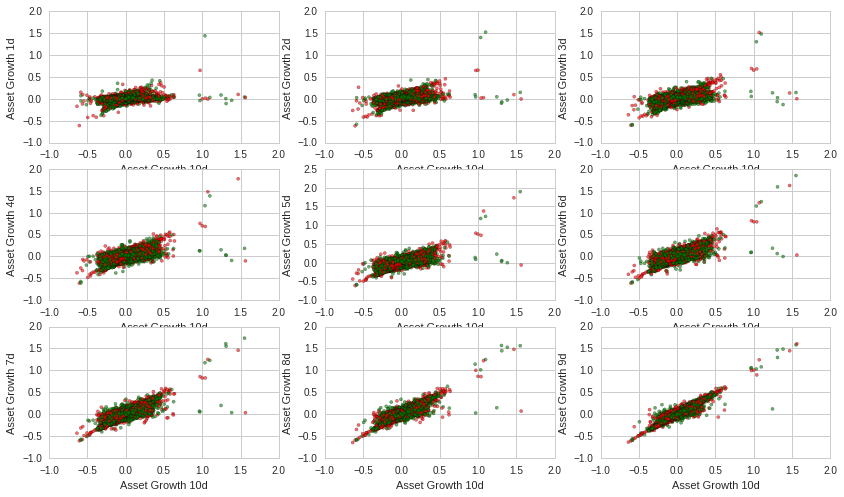

In [27]:
plt.subplot(3, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 1d')

plt.subplot(3, 3, 2)
plt.scatter(X[:, 0], X[:, 2], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 2d')

plt.subplot(3, 3, 3)
plt.scatter(X[:, 0], X[:, 3], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 3d')

plt.subplot(3, 3, 4)
plt.scatter(X[:, 0], X[:, 4], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 4d')

plt.subplot(3, 3, 5)
plt.scatter(X[:, 0], X[:, 5], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 5d')

plt.subplot(3, 3, 6)
plt.scatter(X[:, 0], X[:, 6], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 6d')

plt.subplot(3, 3, 7)
plt.scatter(X[:, 0], X[:, 7], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 7d')

plt.subplot(3, 3, 8)
plt.scatter(X[:, 0], X[:, 8], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 8d')

plt.subplot(3, 3, 9)
plt.scatter(X[:, 0], X[:, 9], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 9d')

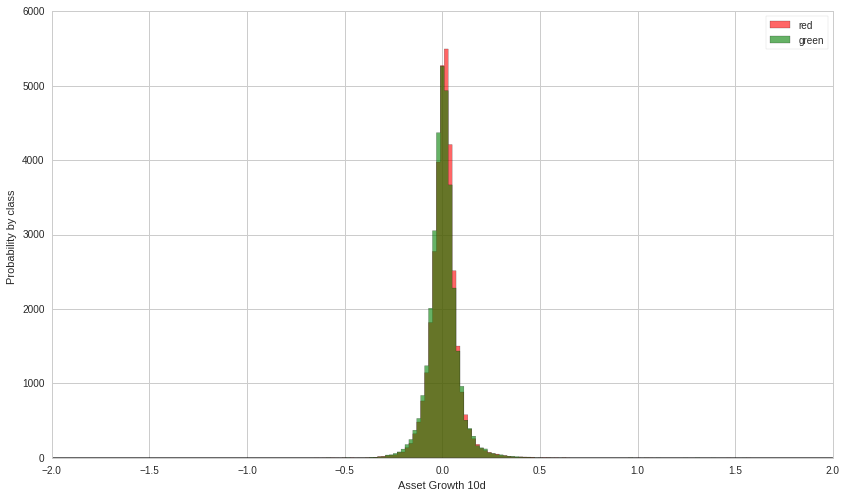

In [28]:
x = X[:,0]

mask = (Y == 1)
xg = x[mask]

mask = (Y == -1)
xr = x[mask]

xlim = (-2, 2)
bins = np.linspace(xlim[0], xlim[1], 200)

plt.hist(xr, bins, alpha=0.6,  histtype='stepfilled', label='red',  color='red')
plt.hist(xg, bins, alpha=0.6,  histtype='stepfilled', label='green', color='green' )
plt.legend(loc='upper right')
plt.xlabel('Asset Growth 10d')
plt.ylabel('Probability by class ')
plt.show()

In [29]:
import pandas as pd
labels = ['Asset Growth 10d',
          'Asset Growth 1d',
          'Asset Growth 2d',
          'Asset Growth 3d',
          'Asset Growth 4d',
          'Asset Growth 5d',
          'Asset Growth 6d',
          'Asset Growth 7d',
          'Asset Growth 8d',
          'Asset Growth 9d']      
df = pd.DataFrame(X_train, columns=labels)
df['target'] = Y_train
df.sample(20)

,Asset Growth 10d,Asset Growth 1d,Asset Growth 2d,Asset Growth 3d,Asset Growth 4d,Asset Growth 5d,Asset Growth 6d,Asset Growth 7d,Asset Growth 8d,Asset Growth 9d,target
14431,0.062092,0.001642,-0.008666,-0.008263,-0.007860,0.001779,0.008124,0.022201,0.024633,0.047653,1.0
49541,0.018792,0.013524,0.020833,0.014331,0.042980,-0.013932,0.021242,0.048560,0.032415,0.038305,-1.0
44566,0.060956,-0.012775,0.023847,0.035925,0.024390,0.041509,0.022763,0.044324,0.037037,0.081142,-1.0
34319,0.001073,0.002686,0.000804,0.021344,0.026681,0.027388,0.012615,0.014818,0.010833,0.014956,1.0
50822,-0.025618,0.006616,0.005666,-0.003742,-0.002809,-0.022936,-0.021140,-0.037071,-0.030937,-0.019337,-1.0
21310,0.009517,-0.021986,-0.058060,-0.025442,-0.049621,-0.039024,-0.044352,-0.041696,-0.060627,-0.030239,1.0
61544,0.017316,-0.082031,-0.085603,-0.036885,0.039823,0.030702,0.017316,0.026201,0.000000,0.017316,-1.0
51339,0.010085,0.009302,-0.005348,0.021978,0.032514,-0.003826,-0.006865,0.006182,0.003855,0.009302,1.0
28161,0.043269,-0.060606,-0.018100,-0.048246,-0.033408,0.048309,0.023585,-0.022523,-0.060606,0.058537,-1.0
193,0.024155,0.000000,0.000000,0.009524,-0.027523,-0.009346,-0.011655,-0.004695,0.004739,0.026634,-1.0


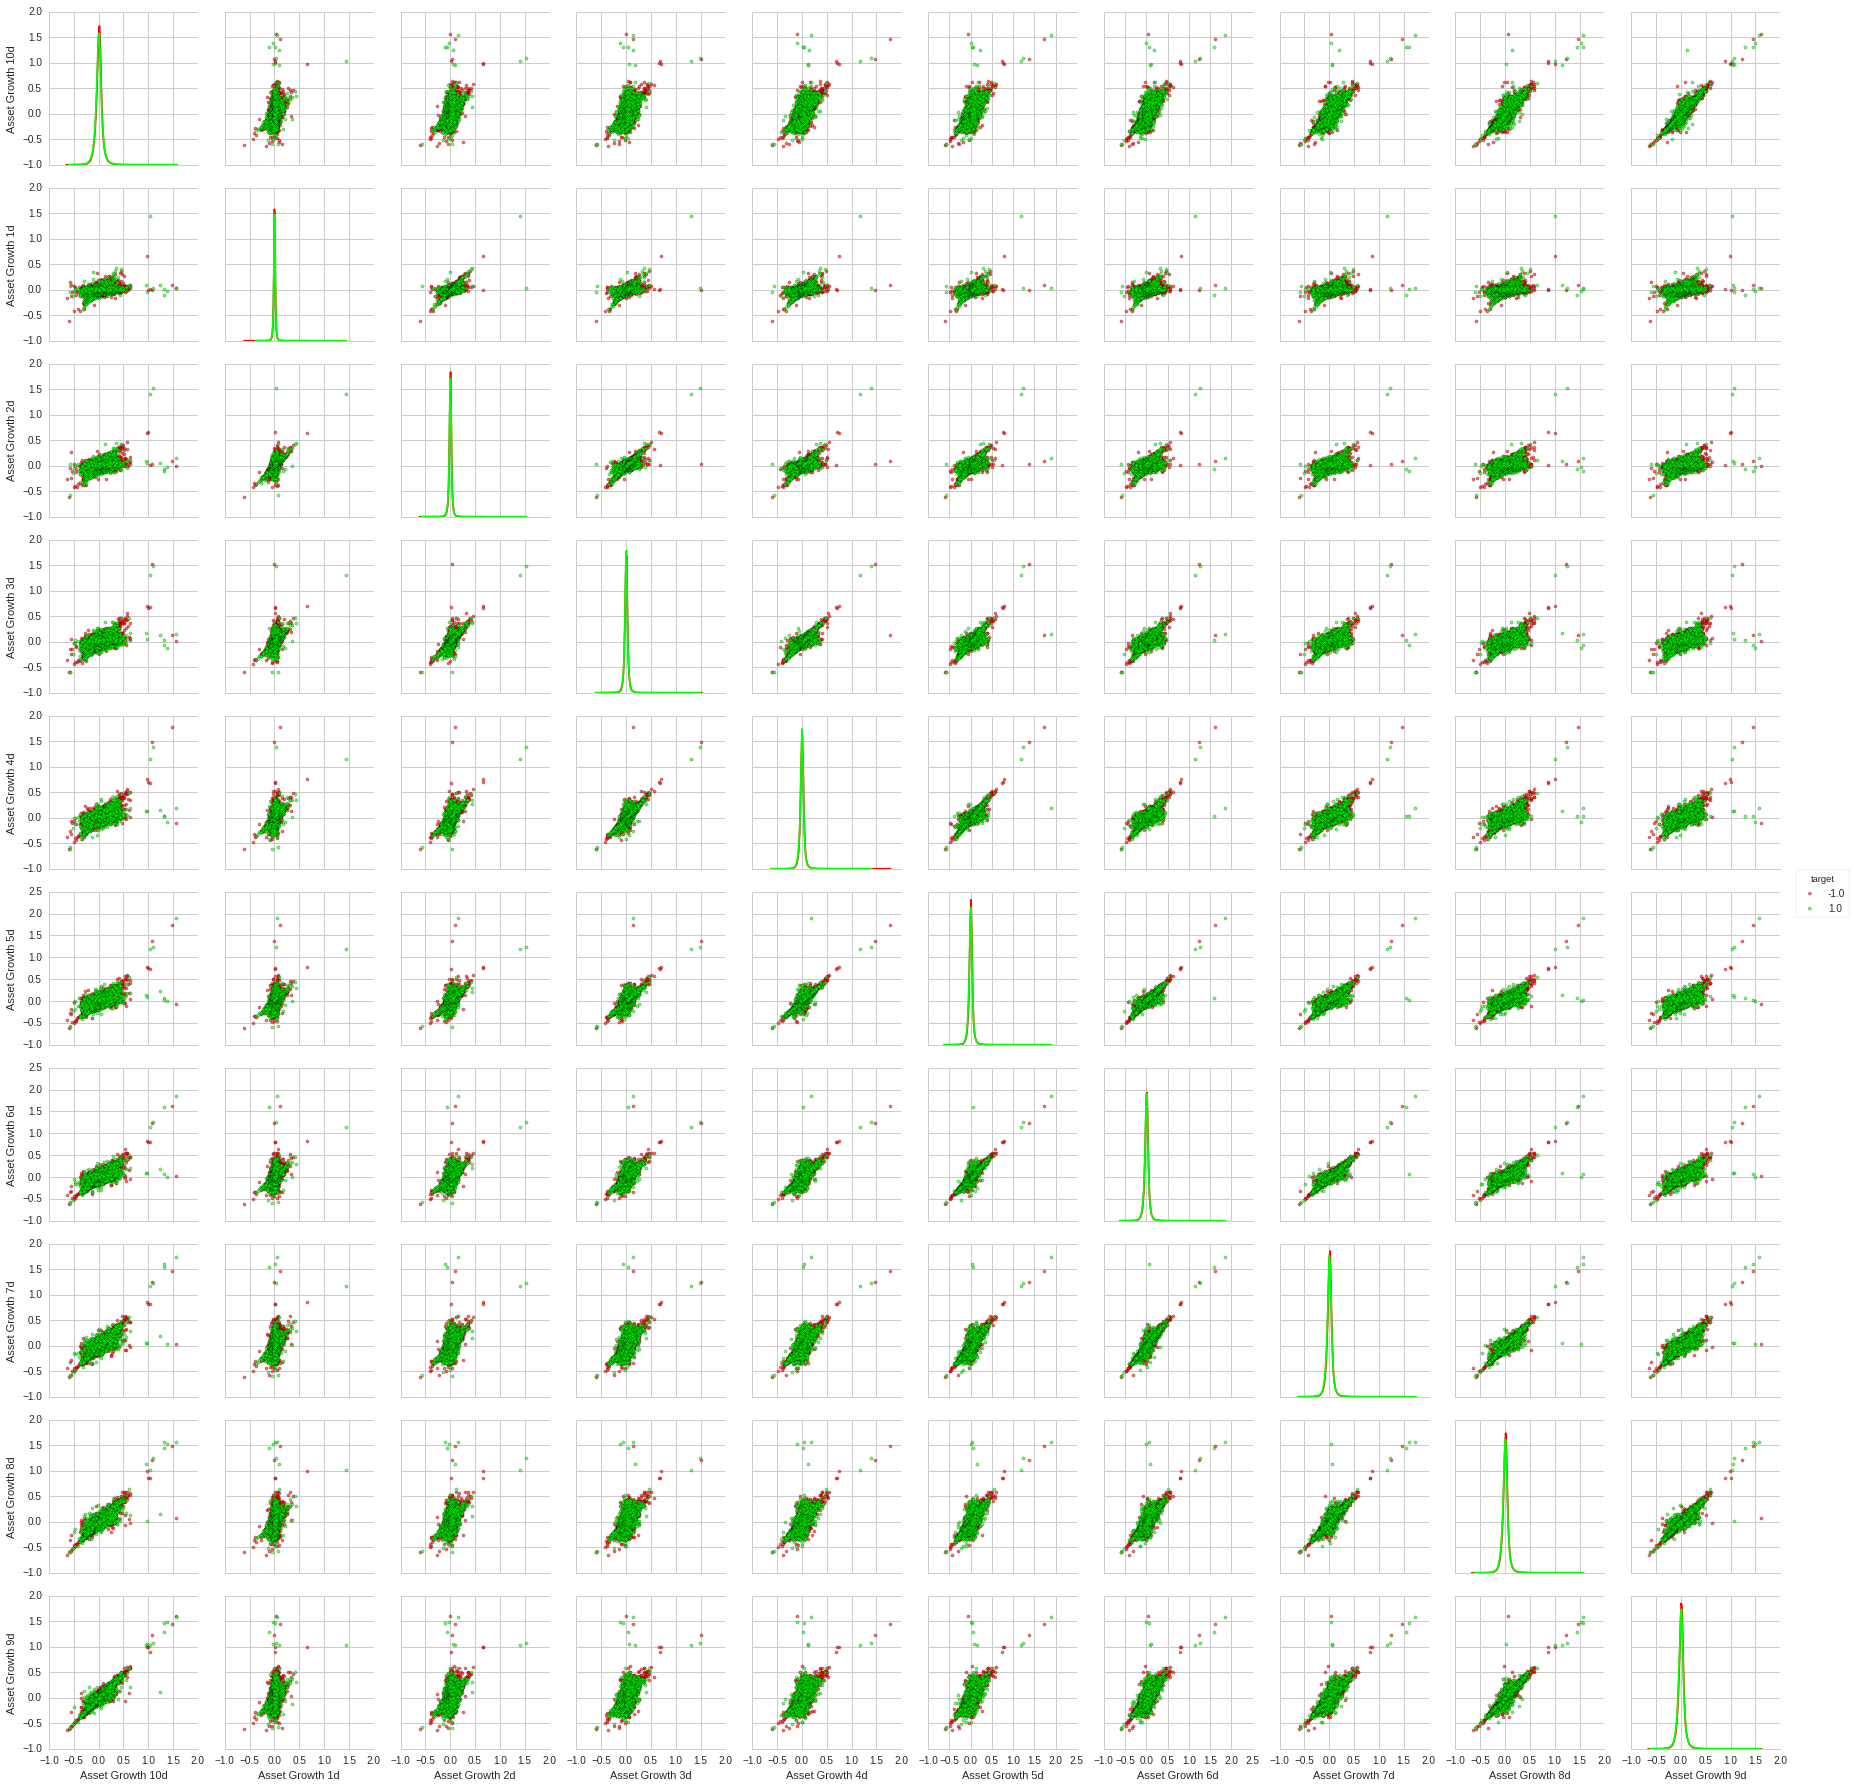

In [30]:
import seaborn as sns
sns.set()
palette = ['#FF0000','#00FF00']
sns.set_palette(palette)
sns.pairplot(df, vars=labels,  hue='target', diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 10, 'edgecolor': 'k'});

## Train the Gaussian Naive Bayes model

In [ ]:
start_timer = time()
from sklearn import svm

# Train classifier
#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()
#clf.fit(X_train, Y_train);

clf = svm.SVC()
#clf = tree.DecisionTreeClassifier()
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
        
clf.fit(X_train, Y_train);
 
end_timer = time()

In [ ]:
print "Time to train : %0.2f secs" % (end_timer - start_timer)

In [ ]:
from sklearn import metrics

Y_pred = clf.predict(X_train)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train, Y_pred) * 100))

In [ ]:
# Predict!
Y_pred = clf.predict(X_test)

Y_pred_prob = clf.predict_proba(X_test)

In [ ]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100

In [ ]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test, Y_pred_prob)))